# Calculate and plot meridional heat transport

## Uses two methods because of diagnostics available:
- From surface heat flux assuming steady state
- From temp_yflux_adv diagnostic (so does not include submeso or gm/diffusion if they are on)

In [11]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 46769:127.0.0.1:46769 vdi-n16.nci.org.au -l rmh561


Client Scheduler: tcp://127.0.0.1:45212 Dashboard: http://127.0.0.1:46769/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [4]:
# Infer from surface heat flux:
def find_MHF(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)
    shflux_am = shflux.mean('time').load()
    area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
    lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

In [ ]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('meridional_heat_transport')

In [5]:
# use temp_yflux_adv diagnostics:
def find_MHF_tempadv(ekey):
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    if (ekey == '01deg'):
        temp_yflux_adv = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_adv_int_z',
                                            n=n_files, time_units = time_units, offset=offset, use_cache=True)
        #temp_yflux_submeso = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_submeso_int_z',
        #                                    n=n_files, time_units = time_units, offset=offset)
        MHF = temp_yflux_adv.mean('time').sum('xt_ocean').load()
        #MHF = temp_yflux_submeso.mean('time').sum('xt_ocean').load()
    else:
        temp_yflux_adv = cc.get_nc_variable(expt, 'ocean.nc', 'temp_yflux_adv',
                                            n=n_files, time_units = time_units, offset=offset, use_cache=True)
        MHF = temp_yflux_adv.mean('time').sum('st_ocean').sum('xt_ocean').load()

    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yu_ocean',n=1).load()
    return latv, MHF

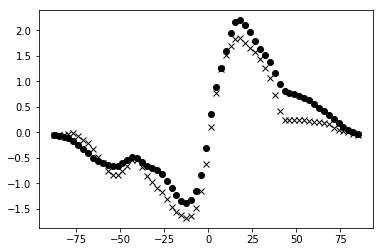

In [6]:
# Read in observed meridional heat transport from Trenberth and Caron (http://www.cgd.ucar.edu/cas/catalog/ocean/ohts/rean_ohts.html)
#f = open('ANNUAL_TRANSPORTS_1985_1989.ascii.txt', 'r') # 'r' = read
df=pd.read_csv('ANNUAL_TRANSPORTS_1985_1989.ascii.txt', sep=' ',skiprows=1,skipinitialspace=True)
obs_lat = df.values[:,0]/100.
obs_ncep = df.values[:,4]/100.
obs_ecmwf = df.values[:,5]/100.
#obs_ncep2 = df.values[:,18]/100.
plt.plot(obs_lat,obs_ncep,'xk')
plt.plot(obs_lat,obs_ecmwf,'ok')
#plt.plot(obs_lat,obs_ncep2)
#df.values[:,0]
#array([[ 1. ,  2. ,  3. ],
#       [ 4. ,  5.5,  6. ]])
#my_data = genfromtxt(, delimiter=' ', dtype=None)
#print(my_data)
#f.close()from astropy.io import ascii
#data = ascii.read("ANNUAL_TRANSPORTS_1985_1989.ascii")
#print(data)

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean_month.nc_net_sfc_heating_-12_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71d9203030>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71bf7668f0>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71f4148570>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean.nc_temp_yflux_adv_-12_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71bf7c2650>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_ocean_month.nc_net_sfc_heating_-30_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71bcc44d50>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71f4148650>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71bf766490>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_ocean.nc_temp_yflux_adv_-30_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71d9993490>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_net_sfc_heating_None_days-since-0001-01-01_None_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71bd589d50>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71a70d8f10>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f71bd255d50>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_temp_yflux_adv_int_z_None_days-since-0001-01-01_None_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140128746305280 and this is thread id 140127032919808.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f719b36b490>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

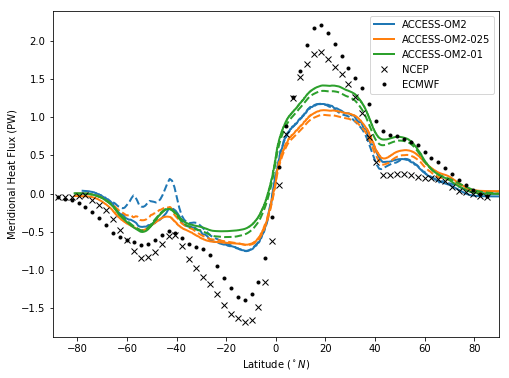

In [20]:
# plot both surface heat flux, temp_yflux_adv methods and observations:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)
    latv_adv, MHF_adv = find_MHF_tempadv(ekey)

    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])# + ' surface heat flux')
    plt.plot(latv_adv,MHF_adv/1.e15,'--',linewidth=2, label='',color=hand[0].get_color())#, label=exptdata.exptdict[ekey]['desc'] + ' resolved advection',color=hand[0].get_color())

plt.plot(obs_lat,obs_ncep,'xk',label='NCEP', markersize=6)
plt.plot(obs_lat,obs_ecmwf,'ok',label='ECMWF', markersize=3)
plt.legend()
plt.xlim([-90.,90.])

savefigure('meridional_heat_transport_withadv_withobs')

In [ ]:
cc.get_ncfiles(exptdata.exptdict['1deg']['expt'])

In [ ]:
cc.get_variables(exptdata.exptdict['01deg']['expt'],'ocean_month.nc')